In [1]:
# switch to base wd first for ape project to work properly
import os
from pathlib import Path

if Path(*Path(os.getcwd()).parts[-2:]) == Path('spearbit-seminar-2023-02/notebook'):
    os.chdir('..')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ape_risk import strategies
from ape import accounts, chain, Contract, networks, project

In [4]:
# load historical prices from csv
FILENAME = "notebook/data/prices.csv"
df = pd.read_csv(FILENAME)

In [5]:
df

,block_number,price0,price1
0,15988366,16529.622589,1203.059067
1,15988416,16539.268987,1203.240073
2,15988466,16544.336096,1204.552935
3,15988516,16542.956053,1204.433249
4,15988566,16535.865160,1203.878763
...,...,...,...
12955,16636116,22896.373768,1585.935149
12956,16636166,22995.358910,1590.290496
12957,16636216,23024.042996,1593.725243
12958,16636266,23339.757077,1632.555198


<Axes: xlabel='block_number'>

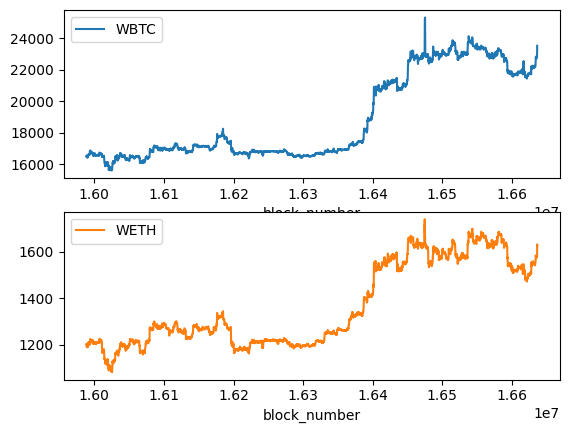

In [6]:
# plot historical data to view
fig, ax = plt.subplots(2, 1)
df.plot(x='block_number', y='price0', label='WBTC', color='C0', ax=ax[0])
df.plot(x='block_number', y='price1', label='WETH', color='C1', ax=ax[1])

In [7]:
df['price0_rel'] = df['price0'] / df['price0'].iloc[0]
df['price1_rel'] = df['price1'] / df['price1'].iloc[0]

<Axes: xlabel='block_number'>

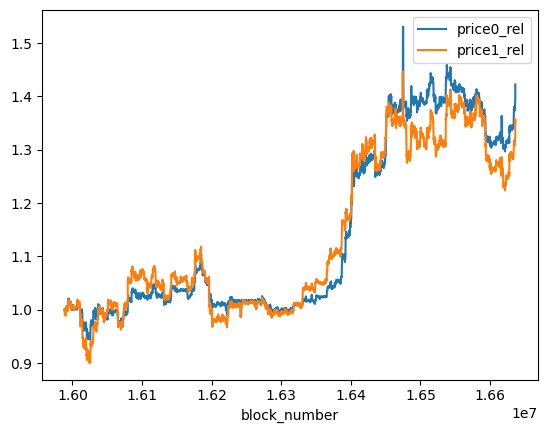

In [8]:
# plot relatives to see how correlated more easily
df.plot(x='block_number', y=['price0_rel', 'price1_rel'])

In [9]:
# filter pandas and form list of list to use as hist data in ape risk strategy
hist_data = df.filter(items=['price0_rel', 'price1_rel']).to_numpy().tolist()

In [10]:
hist_data[:10]

[[1.0, 1.0],
 [1.0005835824899296, 1.0001504547191615],
 [1.000890129604863, 1.001241724732757],
 [1.0008066405652796, 1.0011422400742556],
 [1.0003776596401923, 1.000681342898602],
 [1.0003526553031126, 0.9997943569463963],
 [1.0003422876673196, 1.0002141832625877],
 [0.9998409876971488, 1.0002550670327066],
 [0.9990625137884044, 0.9998445817829237],
 [0.9986525399025622, 0.9994665275337501]]

In [11]:
# simulate 1 month of relative data (i.e. ~4320 10m candles) fitting from hist data for WBTC/USD and WETH/USD
strat = strategies.multi_gbms(
    initial_value=1.0,
    num_points=4320,
    num_rvs=2,
    params=[0, 1],
    scale=[[1, 0], [0, 1]],
    shift=[0, 0],
    hist_data=hist_data
)

In [12]:
# for going to risk neutral measure ...
r = 0.04 * ((600) / (86400 * 365))  # consensus ETH staking rate as RN rate in 10 min terms

In [13]:
ts = np.arange(0, 4320)

In [14]:
mus = np.mean(np.diff(np.log(np.asarray(hist_data)), axis=0), axis=0)
mus

array([2.71976663e-05, 2.33446554e-05])

In [15]:
sigmas = np.std(np.diff(np.log(np.asarray(hist_data)), axis=0), axis=0)
sigmas

array([0.00120671, 0.00146652])

In [20]:
q_shift = np.array([np.cumsum([r - (mus[i] + sigmas[i]**2 / 2) for _ in range(4320)]) for i in range(2)])
q_shift

array([[-2.71647087e-05, -5.43294174e-05, -8.14941262e-05, ...,
        -1.17297212e-01, -1.17324377e-01, -1.17351542e-01],
       [-2.36589640e-05, -4.73179280e-05, -7.09768920e-05, ...,
        -1.02159407e-01, -1.02183066e-01, -1.02206724e-01]])

In [21]:
q_factor = np.exp(q_shift).T
q_factor

array([[0.99997284, 0.99997634],
       [0.99994567, 0.99995268],
       [0.99991851, 0.99992903],
       ...,
       [0.88932084, 0.90288561],
       [0.88929668, 0.90286425],
       [0.88927252, 0.90284289]])

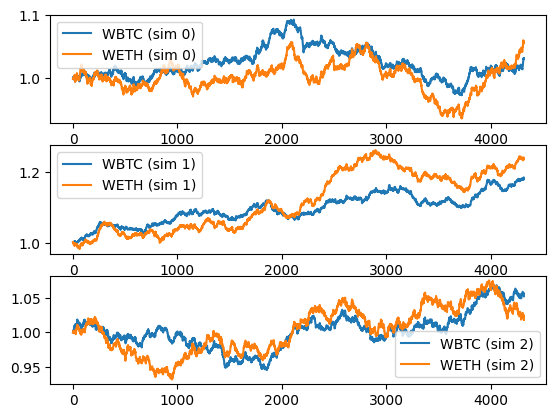

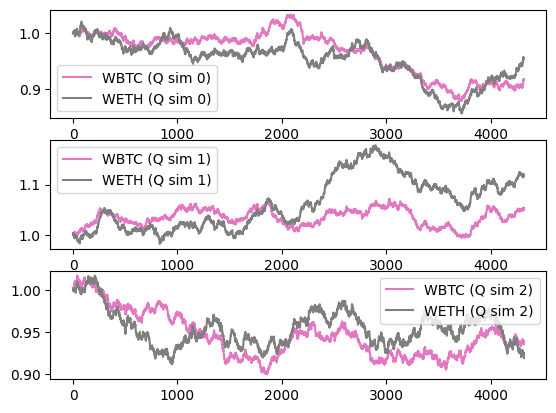

In [24]:
# plot 3 example sims generated from fit to hist data both in physical and risk neutral measures
NUM_SIMS = 3
fig, ax = plt.subplots(NUM_SIMS, 1)
fig_q, ax_q = plt.subplots(NUM_SIMS, 1)
for i in range(NUM_SIMS):
    # generates a single Monte Carlo sim via strat.example()
    ex = strat.example()
    ex = ex.reshape(4320, 2)

    # physical measure
    df_ex = pd.DataFrame(ex, columns=[f'WBTC (sim {i})', f'WETH (sim {i})'])
    df_ex.plot(ax=ax[i], color=['C0', 'C1'])
    
    # risk neutral measure
    ex_q = ex * q_factor
    df_ex_q = pd.DataFrame(ex_q, columns=[f'WBTC (Q sim {i})', f'WETH (Q sim {i})'])
    df_ex_q.plot(ax=ax_q[i], color=['C6', 'C7'])